In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
%reload_ext sql

In [5]:
data = pd.read_excel("loandataproject.xlsx", sheet_name='Data')

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [6]:
data.columns

Index(['LOAN_NUMBER', 'SAMPLE_DATE', 'FILE_REQ_DATE', 'SECOND_REQUEST_DATE',
       'SENT_TO_IMAGING_DATE', 'LENDER_RESPONSE_DUE_DATE',
       'DATE_LOAN_FINALIZED', 'LENDER_ID', 'LENDER_NAME', 'LENDER_LOAN_ID',
       'PROP_STATE', 'NEW_CONSTRUCTION_INDICATOR', 'CONDOMINIUM_INDICATOR',
       'LOAN_ORIG_DATE', 'CURRENT_BALANCE', 'FICO_SCORE', 'LTV', 'ORIG_VALUE',
       'AVM_VALUE', 'FIELD_REVIEW_VALUE_SUPPORTED', 'FIELD_REVIEW_VALUE',
       'PURPOSE_CODE', 'OCCUPANCY_CODE', 'LENDER_INST_TYPE_DESCRIPTION',
       'UNDERWRITER_NAME', 'REVIEW_DATE', 'REVIEW_STATUS', 'DEAL_NAME',
       'START_DATE'],
      dtype='object')

In [7]:
data['LENDER_INST_TYPE_DESCRIPTION'].unique()

array(['Bank Owned Mortgage Company - National',
       'Mortgage Banker - Bank Owned', 'Mortgage Banker - (Large)',
       'Credit Unions', 'Community Banks'], dtype=object)

In [8]:
engine = create_engine('sqlite:///loandata.sql', echo=False)
data.to_sql('loandata', con=engine, if_exists='replace')
os.environ["DATABASE_URL"]='sqlite:///loandata.sql'

Data by Lender Institution Type: Average, Maximum, Minimum of Current Balance and the total loan count

In [9]:
%%sql
WITH cte AS (
SELECT DISTINCT LENDER_INST_TYPE_DESCRIPTION, COUNT(LOAN_NUMBER) OVER(PARTITION BY LENDER_INST_TYPE_DESCRIPTION) AS COUNT,
        AVG(CURRENT_BALANCE) OVER(PARTITION BY LENDER_INST_TYPE_DESCRIPTION) AS AVG_CURRENT_BALANCE,
        MAX(CURRENT_BALANCE) OVER(PARTITION BY LENDER_INST_TYPE_DESCRIPTION) AS MAX_CURRENT_BALANCE,
        MIN(CURRENT_BALANCE) OVER(PARTITION BY LENDER_INST_TYPE_DESCRIPTION) AS MIN_CURRENT_BALANCE
FROM loandata )

SELECT *
FROM cte
UNION ALL 
SELECT "Total", SUM(COUNT), AVG_CURRENT_BALANCE, MAX_CURRENT_BALANCE, MIN_CURRENT_BALANCE
FROM cte

Done.


LENDER_INST_TYPE_DESCRIPTION,COUNT,AVG_CURRENT_BALANCE,MAX_CURRENT_BALANCE,MIN_CURRENT_BALANCE
Bank Owned Mortgage Company - National,187,242899.80213903743,720000,43225
Community Banks,499,211839.96392785572,729750,28500
Credit Unions,374,175149.60160427808,578250,22500
Mortgage Banker - (Large),279,260374.3835125448,729750,59000
Mortgage Banker - Bank Owned,661,236262.68986384265,625500,25018
Total,2000,242899.80213903743,720000,43225


REPORT 2: Data by LTV (Loan to Value) Cohorts: Average, Maximum, and Minimum Current Balance

In [10]:
%%sql
WITH cohorts AS (
SELECT CASE WHEN LTV <= 85 THEN '<=85%'
            WHEN LTV >85 AND LTV <=90 THEN '>85% and <=90%'
            WHEN LTV >90 AND LTV <=95 THEN '>90% and <=95%'
            WHEN LTV >95 THEN '>95%'
            ELSE NULL END LOAN_TO_VALUE_COHORTS,
       LOAN_NUMBER, CURRENT_BALANCE
FROM loandata),

    aggregations AS (
SELECT DISTINCT LOAN_TO_VALUE_COHORTS, COUNT(LOAN_NUMBER) OVER(PARTITION BY LOAN_TO_VALUE_COHORTS) AS COUNT,
        AVG(CURRENT_BALANCE) OVER(PARTITION BY LOAN_TO_VALUE_COHORTS) AS AVG_CURRENT_BALANCE, 
        MAX(CURRENT_BALANCE) OVER(PARTITION BY LOAN_TO_VALUE_COHORTS) AS MAX_CURRENT_BALANCE, 
        MIN(CURRENT_BALANCE) OVER(PARTITION BY LOAN_TO_VALUE_COHORTS) AS MIN_CURRENT_BALANCE
FROM cohorts 
WHERE LOAN_TO_VALUE_COHORTS IS NOT NULL)

SELECT * 
FROM aggregations
UNION ALL 
SELECT 'Total', SUM(COUNT), AVG_CURRENT_BALANCE, MAX_CURRENT_BALANCE,
    MIN_CURRENT_BALANCE
FROM aggregations
            

 * sqlite:///loandata.sql
Done.


LOAN_TO_VALUE_COHORTS,COUNT,AVG_CURRENT_BALANCE,MAX_CURRENT_BALANCE,MIN_CURRENT_BALANCE
<=85%,344,223985.91279069768,729750,43300
>85% and <=90%,823,235966.17861482382,729750,22500
>90% and <=95%,796,209504.33542713567,561700,28500
>95%,37,200910.1891891892,371510,65475
Total,2000,223985.91279069768,729750,43300


REPORT 3: Data by Loan Age Cohort (Loan Age = 6/1/2013 minus LOAN_ORIG_DATE in months): Average, Maximum, and Minimum Current Balance

In [11]:
%%sql
WITH loan_age AS (
SELECT LOAN_NUMBER, CURRENT_BALANCE, ((julianday('2013-06-01')-julianday(LOAN_ORIG_DATE))/(365/12)) AS LOAN_AGE
FROM loandata ),

    loan_age_cohorts AS (
        SELECT CASE WHEN LOAN_AGE >=0 AND LOAN_AGE <10 THEN '0 - 9 Months'
                    WHEN LOAN_AGE >=10 AND LOAN_AGE <20 THEN '10 - 19 Months'
                    WHEN LOAN_AGE >=20 AND LOAN_AGE <30 THEN '20 - 29 Months'
                    WHEN LOAN_AGE >=30 AND LOAN_AGE <40 THEN '30 - 39 Months'
                    WHEN LOAN_AGE >=40 THEN '>=40 Months'
                    ELSE 'Unknown' END loan_age_cohorts,
            LOAN_NUMBER, CURRENT_BALANCE, LOAN_AGE
    FROM loan_age
    ),
    aggregations AS (
SELECT DISTINCT loan_age_cohorts, COUNT(LOAN_NUMBER) OVER(PARTITION BY loan_age_cohorts) AS COUNT,
                                  AVG(CURRENT_BALANCE) OVER(PARTITION BY loan_age_cohorts) AS AVG_CURRENT_BALANCE, 
                                    MAX(CURRENT_BALANCE) OVER(PARTITION BY loan_age_cohorts) AS MAX_CURRENT_BALANCE,
                                    MIN(CURRENT_BALANCE) OVER(PARTITION BY loan_age_cohorts) AS MIN_CURRENT_BALANCE
            FROM loan_age_cohorts)
SELECT * 
FROM aggregations        

Union ALL

SELECT 'Total', SUM(COUNT), AVG_CURRENT_BALANCE, MAX_CURRENT_BALANCE, MIN_CURRENT_BALANCE
FROM aggregations

 * sqlite:///loandata.sql
Done.


loan_age_cohorts,COUNT,AVG_CURRENT_BALANCE,MAX_CURRENT_BALANCE,MIN_CURRENT_BALANCE
0 - 9 Months,316,234278.21202531646,562500,45000
10 - 19 Months,729,229097.61179698218,720000,25018
20 - 29 Months,522,212228.40421455938,729750,22500
30 - 39 Months,243,206224.48971193415,546376,41705
>=40 Months,174,226481.55172413794,729750,35000
Unknown,16,256425.3125,404700,88065
Total,2000,234278.21202531646,562500,45000


REPORT 4: Create a Crosstab Report- SUM of CURRENT_UPB by LTV Cohorts and FICO Cohorts

In [12]:
%%sql
WITH FICO_COHORT AS (
    SELECT LTV, CURRENT_BALANCE,CASE WHEN FICO_SCORE < 600 THEN '0 - 600'
                    WHEN FICO_SCORE >=600 AND FICO_SCORE <700 THEN '600-699'
                    WHEN FICO_SCORE >=700 AND FICO_SCORE <800 THEN '700-799'
                    WHEN FICO_SCORE >=800 THEN '800+'
                    ELSE 'Unknown' END FICO_COHORT
FROM loandata
)
SELECT FICO_COHORT,  
            SUM(CASE WHEN LTV <= 85 THEN 
                    CURRENT_BALANCE ELSE 0 END) "<=85", 
            SUM(CASE WHEN LTV >85 AND LTV <=90 THEN 
                    CURRENT_BALANCE ELSE 0 END) ">85% and <=90%", 
            SUM(CASE WHEN LTV >90 AND LTV <=95 THEN 
                    CURRENT_BALANCE  ELSE 0 END) ">90% and <=95%", 
            SUM(CASE WHEN LTV >95 THEN 
                   CURRENT_BALANCE ELSE 0 END) ">95%"
 
FROM FICO_COHORT
GROUP BY FICO_COHORT


 * sqlite:///loandata.sql
Done.


FICO_COHORT,<=85,>85% and <=90%,>90% and <=95%,>95%
0 - 600,0,247050,0,0
600-699,3260490,14606019,14598016,629990
700-799,60413630,149979009,135188314,5359114
800+,13377034,29368087,16979121,1444573


In [14]:
sql_query = '''

WITH FICO_COHORT AS (
    SELECT LTV, CURRENT_BALANCE,CASE WHEN FICO_SCORE < 600 THEN '0 - 600'
                    WHEN FICO_SCORE >=600 AND FICO_SCORE <700 THEN '600-699'
                    WHEN FICO_SCORE >=700 AND FICO_SCORE <800 THEN '700-799'
                    WHEN FICO_SCORE >=800 THEN '800+'
                    ELSE 'Unknown' END FICO_COHORT
FROM loandata
)
SELECT FICO_COHORT,  
            SUM(CASE WHEN LTV <= 85 THEN 
                    CURRENT_BALANCE ELSE 0 END) "<=85", 
            SUM(CASE WHEN LTV >85 AND LTV <=90 THEN 
                    CURRENT_BALANCE ELSE 0 END) ">85% and <=90%", 
            SUM(CASE WHEN LTV >90 AND LTV <=95 THEN 
                    CURRENT_BALANCE  ELSE 0 END) ">90% and <=95%", 
            SUM(CASE WHEN LTV >95 THEN 
                   CURRENT_BALANCE ELSE 0 END) ">95%"
 
FROM FICO_COHORT
GROUP BY FICO_COHORT

'''

In [15]:
crosstab = pd.read_sql_query(sql_query, con=engine).set_index('FICO_COHORT')
crosstab

,<=85,>85% and <=90%,>90% and <=95%,>95%
FICO_COHORT,,,,
0 - 600,0,247050,0,0
600-699,3260490,14606019,14598016,629990
700-799,60413630,149979009,135188314,5359114
800+,13377034,29368087,16979121,1444573


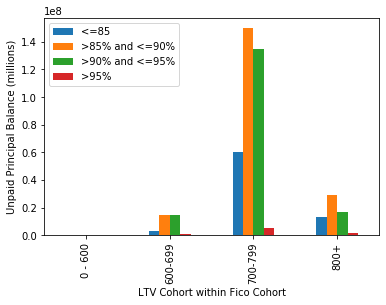

In [16]:
crosstab.plot.bar(ylabel='Unpaid Principal Balance (millions)', xlabel = 'LTV Cohort within Fico Cohort', sort_columns=True)